In [63]:
import croissant as cro
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from pygdsm import GlobalSkyModel2016
import VeryAccurateEmulator as VAE

In [152]:
LMAX = 75
NSIDE = 128
PATH = "ffs"  # efield, power: ascii
beam_dir = Path("./beam") / PATH

In [172]:
nfreqs = len(list(beam_dir.glob("*")))
freqs = np.empty(nfreqs)

for i, f in enumerate(beam_dir.iterdir()):
    freqs[i] = f.stem.split("f=")[1].split(")")[0]
    if i == 0:
        theta, phi = np.loadtxt(f, skiprows=2, usecols=(0, 1)).T
        theta = np.deg2rad(np.unique(theta))
        phi = np.deg2rad(np.unique(phi))
        gain = np.empty((nfreqs, theta.size, phi.size))
    g = np.loadtxt(f, skiprows=2, usecols=2).T
    gain[i] = g.reshape(theta.size, phi.size, order="F")

ix = np.argsort(freqs)
freqs = freqs[ix]
gain = gain[ix]

if PATH == "ffs":
    freqs *= 1e3  # was given in GHz

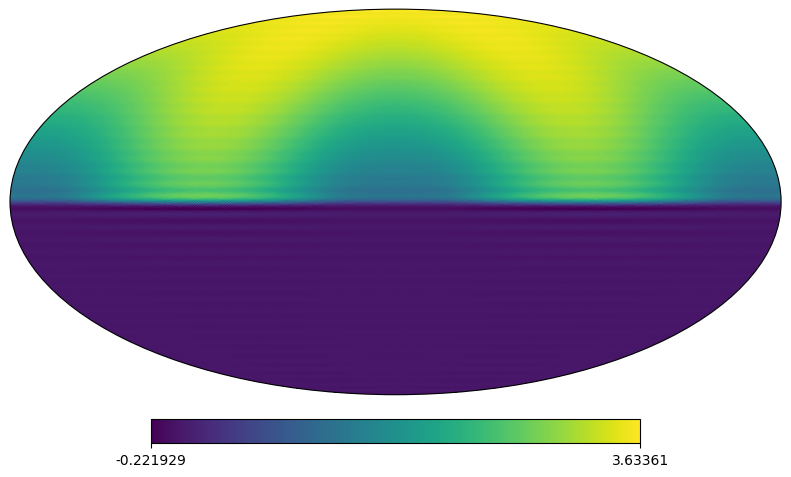

In [173]:
beam = cro.Beam.from_grid(gain, theta, phi, LMAX, nside=NSIDE, frequencies=freqs, coord="T")
beam.horizon_cut(nside=NSIDE)
beam_map = beam.hp_map(NSIDE)
hp.projview(beam_map[0]); plt.show()

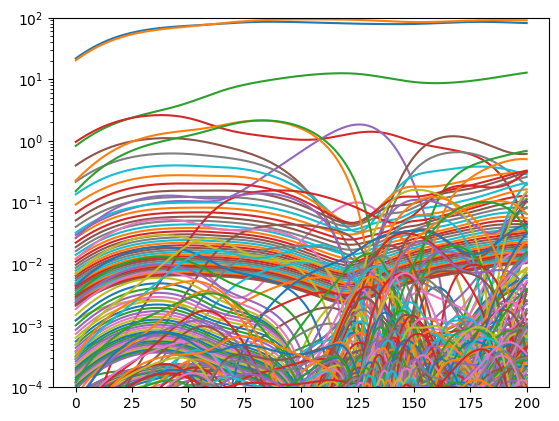

In [169]:
plt.figure()
plt.plot(np.abs(beam.alm)**2)
plt.ylim(1e-4, 1e2)
plt.yscale("log")
plt.show()

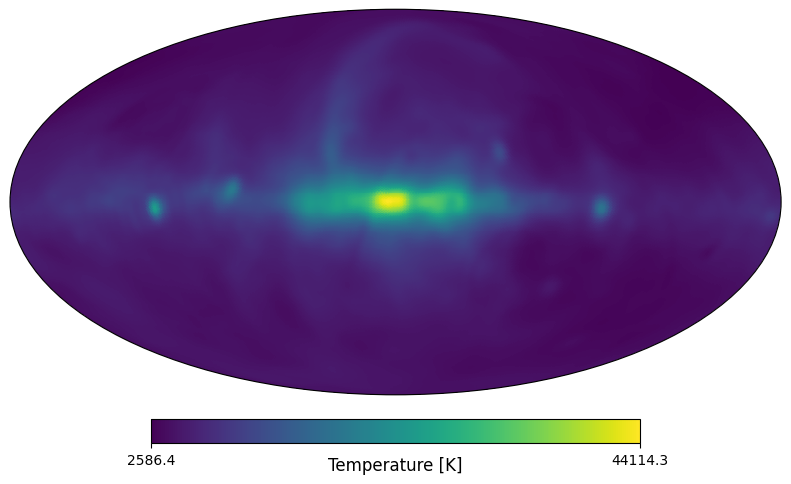

In [174]:
sky = cro.Sky.gsm(freqs, lmax=LMAX)
sky_map = sky.hp_map(NSIDE)
hp.projview(sky_map[0], unit="Temperature [K]"); plt.show()

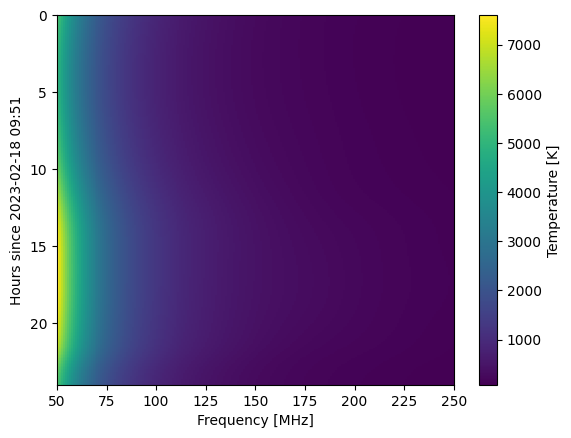

In [175]:
lat = 37.873199
lon = -122.257063
location = (lon, lat)
times = cro.simulator.time_array(t_start="2023-02-18 09:51", t_end="2023-02-19 09:51", N_times=250)
sim_kwargs = {"lmax": LMAX, "frequencies": freqs, "world": "earth", "location": location, "times": times}
sim = cro.Simulator(beam, sky, **sim_kwargs)
sim.run(dpss=False)
sim.plot()

In [176]:
mean = sim.waterfall.mean(axis=0)
d = sim.waterfall - mean
cov = d.T @ d
diag = np.sqrt(np.diag(cov))
corr = cov / (diag[:, None] * diag[None, :])
u, s, vt = np.linalg.svd(corr)

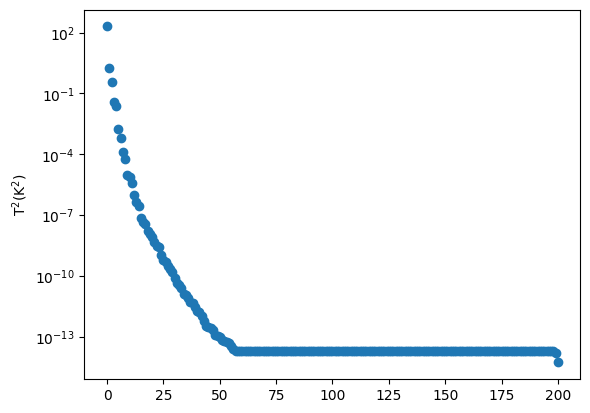

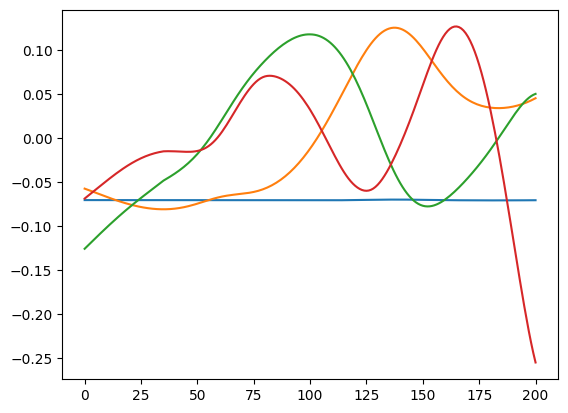

In [177]:
plt.figure()
plt.plot(s, marker="o", ls="")
plt.yscale("log")
plt.ylabel(r"$\rm{T}^2 \left(\rm{K}^2\right) $")
plt.show()

plt.figure()
plt.plot(vt[:4].T)
plt.show()

In [192]:
def gen_eor(freqs, A=0.5, nu0=78.3, w=20.7, tau=7):
    '''Generate a 21cm spectrum using Bowman et al. 2018 parameterization.'''
    B = 4 * (freqs - nu0)**2 / w**2 * np.log(-1/tau * np.log((1+np.exp(-tau))/2))
    return -A * (1 - np.exp(-tau * np.exp(B))) / (1 - np.exp(-tau))

edges = gen_eor(freqs) * 10

# need dayenu probably

1.0008740320464866


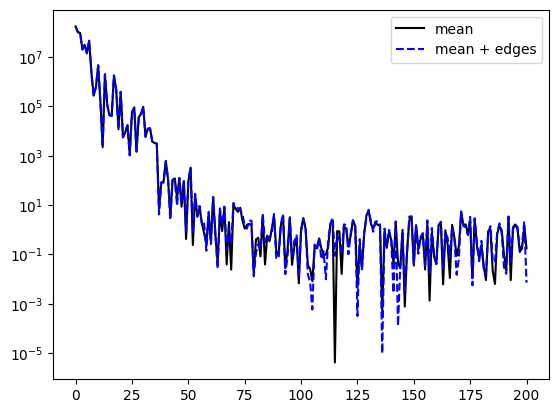

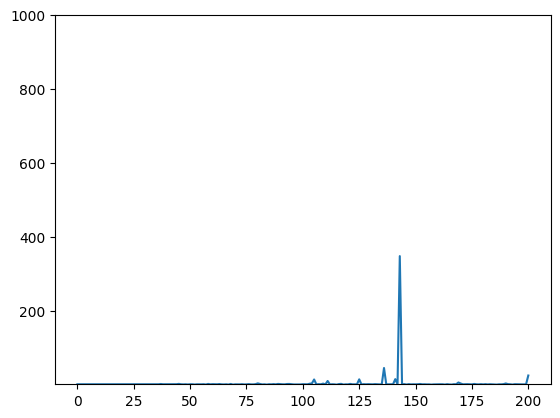

In [194]:
v = vt.T
fg_proj = (d @ v)**2
mean_proj = (mean @ v)**2
edges_proj = ((mean+edges) @ v)**2
print(mean_proj.sum() / edges_proj.sum())

plt.figure()
#plt.plot(fg_proj[::10].T)
plt.plot(mean_proj, lw=None, c="k", label="mean")
plt.plot(edges_proj, lw=None, c="b", ls="--", label="mean + edges")
plt.legend()
plt.yscale("log")
plt.show()

plt.figure()
plt.plot(mean_proj / edges_proj)
plt.ylim(1, 1e3)
plt.show()